In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import category_encoders as ce



df=pd.read_csv('online_shoppers_intention.csv')

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "Max possible profit \n Thresh={:.2f}, Prof={:.5f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
            arrowprops=arrowprops, bbox=bbox_props, ha="center", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.6,0.95), **kw)


def prof(X_test,y_test,thresh=0.5,fp=-0.05):
    probs=model.predict_proba(X_test)[:,1]
    cm=pd.crosstab(y_test,np.where(probs>=thresh,1,0))
    pm=np.array([[0,fp],[-0.1,0.1]])
    return np.sum(cm.values*pm)/X_test.shape[0]

def prof_curve(X_test,y_test,fp=-0.05):
    idx=np.linspace(0,1,101)
    profits=[prof(X_test,y_test,i,fp) for i in idx]
    return idx, profits 

def max_prof(X_test,y_test,fp=-0.05):
    idx=np.linspace(0,1,101)
    profits=[prof(X_test,y_test,i,fp) for i in idx]
    return (np.max(profits),idx[np.argmax(profits)])


def cross_val(X,y,over_under=False,over_=False,cols=None,cb=False):
    mcc_scores=[]
    roc_scores=[]
    rec_scores=[]
    prec_scores=[]
    prof_scores=[]
    prof_dec=[]

    if cols:
        X=X[cols]

    cols2=list(set(X.columns).intersection(set(['VisitorType','Browser','Region','TrafficType','OperatingSystems','Month'])))
    if cb==False:
        X=pd.get_dummies(X,columns=cols2)
    for urgh in range(3):
        kf = KFold(n_splits=5,shuffle=True)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            if cb==True:
                target_enc = ce.TargetEncoder(cols=cols2)
                target_enc.fit(X_train[cols2], y_train) 
                X_train=X_train.drop(columns=cols2).join(target_enc.transform(X_train[cols2]))
                X_test=X_test.drop(columns=cols2).join(target_enc.transform(X_test[cols2]))
            if over_under==True:
                over = SMOTE(sampling_strategy=0.6)
                under = RandomUnderSampler(sampling_strategy=1)
                X_train,y_train=over.fit_resample(X_train,y_train)
                X_train,y_train=under.fit_resample(X_train,y_train)
                print ('over+undersampling!')
            elif over_==True:
                over = SMOTE(sampling_strategy='not majority')
                X_train,y_train=over.fit_resample(X_train,y_train)
                print ('oversampling!')


            model.fit(X_train,y_train)
            prof_scores.append(max_prof(X_test,y_test)[0])
            prof_dec.append(max_prof(X_test,y_test)[1])
            preds=model.predict(X_test)
            mcc_scores.append(matthews_corrcoef(y_test,preds))
            roc_scores.append(roc_auc_score(y_test,preds))
            prec_scores.append(precision_score(y_test,preds))
            rec_scores.append(recall_score(y_test,preds))
    return (model,np.mean(mcc_scores),np.mean(roc_scores),np.mean(prec_scores),np.mean(rec_scores),np.mean(prof_scores),np.mean(prof_dec))



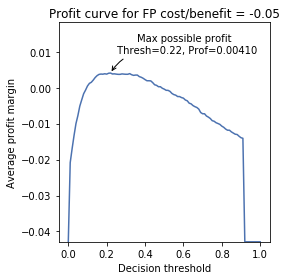

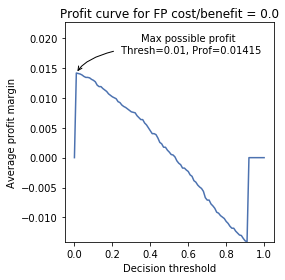

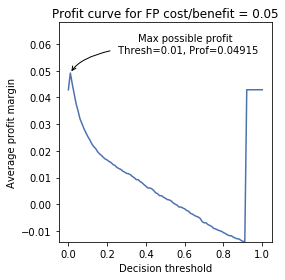

In [60]:
for fp in [-0.05,0.0,0.05]:

    df=pd.read_csv('online_shoppers_intention.csv')

    cols=list(set(df.columns).intersection(set(['VisitorType','Browser','Region','TrafficType','OperatingSystems','Month'])))

    df=pd.get_dummies(df,columns=cols)
    df['Weekend']=df['Weekend'].astype(int)
    df['Revenue']=df['Revenue'].astype(int)
    y=df['Revenue']
    X=df.drop(columns='Revenue')

    X, X_final, y, y_final = train_test_split(X,y,test_size=0.2,random_state=1)

    model=RandomForestClassifier(random_state=2)
    model.fit(X,y)
    preds=model.predict(X_final)

    fig,ax=plt.subplots(figsize=(4,4))

    x_,y_=prof_curve(X_final,y_final,fp=fp)
    ax.plot(x_,y_)
    ax.set_xlabel('Decision threshold')
    ax.set_ylabel('Average profit margin')
    ax.set_title('Profit curve for FP cost/benefit = {}'.format(fp))
    ax.set_ylim(min(y_),max(y_)+0.3*(max(y_)-min(y_)))

    annot_max(np.array(x_),np.array(y_),ax=ax)
    fig.tight_layout()
    plt.savefig('fp_curve_' + str(fp) + '.svg',bbox_inches = 'tight')

In [61]:
rf_scores=[max_prof(X_final,y_final)[0],
             matthews_corrcoef(y_final,preds),
             precision_score(y_final,preds),
             recall_score(y_final,preds)]


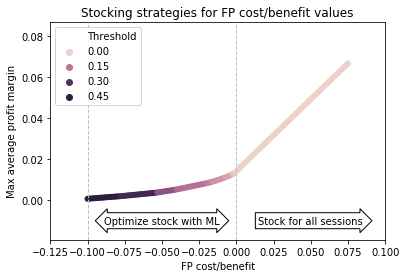

In [62]:

x_=np.linspace(-0.1,0.075,150)
y_=np.vstack([max_prof(X_final,y_final,fp=i) for i in x_])

df_mp=pd.DataFrame({'FP cost/benefit':x_,'Max average profit margin':y_[:,0],'Threshold':y_[:,1]})

fig,ax=plt.subplots()
ax=sns.scatterplot(df_mp['FP cost/benefit'],df_mp['Max average profit margin'],hue=df_mp['Threshold'],linewidth=0)
ax.axvline(x=0,color='0.75',linewidth=1,linestyle='--')
ax.axvline(x=-.1,color='0.75',linewidth=1,linestyle='--')
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="k", lw=1)
t = ax.text(0.05, -0.01, "Stock for all sessions", ha="center", va="center",
            size=10,
            bbox=bbox_props)

bbox_props = dict(boxstyle="darrow,pad=0.3", fc="white", ec="k", lw=1)
t = ax.text(-0.05, -0.01, "Optimize stock with ML", ha="center", va="center",
            size=10,
            bbox=bbox_props)
ax.set_xlim(-0.125,0.1)
ax.legend(loc='upper left')

ax.set_title('Stocking strategies for FP cost/benefit values')
plt.savefig('prof_range.svg')

In [63]:
# #This cell (commented out) was used for model evaluation
# import random

# df=pd.read_csv('online_shoppers_intention.csv')

# df['Weekend']=df['Weekend'].astype(int)
# df['Revenue']=df['Revenue'].astype(int)
# y=df['Revenue']
# X=df.drop(columns='Revenue')

# X, X_final, y, y_final = train_test_split(X,y,test_size=0.2,random_state=1)

# lst=[]


# while 10>0: #I ran this overnight
#     i=random.choice([None,10,20,30])
#     j=random.choice([2, 5,7,9])
#     k=random.choice([1,2,3,4])
#     l=random.choice([25,50,100,200,500])
#     m=random.choice([0.05,0.1,0.2,0.3,0.4])
#     cols=random.sample(list(X.columns),random.randint(10,len(X.columns)))
#     over_samp=random.choice([True,False])
    
#     model=XGBClassifier(max_depth=i,
#                             min_samples_split=j,
#                             min_samples_leaf=k,
#                             n_estimators=l,
#                             learning_rate=m,
#                             n_jobs=-1)
#     lst.append((cross_val(X,y,over_=over_samp,cols=cols,cb=True),cols,over_samp))
#     print (lst[-1],len(lst))

In [64]:
# #Make a dataframe of results and save to csv
# results=pd.DataFrame(columns=['model','MCC','roc','precision','recall','profit','thresh'],data=np.vstack([lst[i][0] for i in range(len(lst))]))
# results['cols']=np.vstack(lst)[:,-2]
# results['over']=np.vstack(lst)[:,-1]
# results.to_csv('osi_results.csv')

In [65]:
import ast

#Previously computed model evaluation results are loaded from this csv file
results=pd.read_csv('osi_results2.csv')
results=results.iloc[:,1:]

def to_dict(x):
    t1=''.join(x.splitlines())

    t2=t1.split('(')[1].replace(')','').split(',')

    t2=[i.strip() for i in t2]
    params={}
    for j in [i.split('=') for i in t2]:
        try:
            params[j[0]]=ast.literal_eval(j[1])
        except:
            pass
    return params

results['model']=results['model'].apply(lambda x: to_dict(x))
results['cols']=results['cols'].apply(lambda x: ast.literal_eval(x))

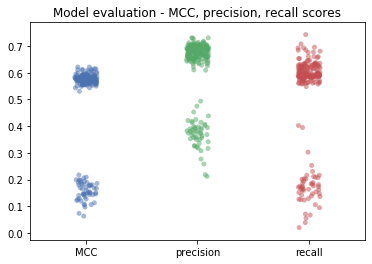

In [66]:
plt.style.use('seaborn-deep')
fig,ax=plt.subplots()
ax=sns.stripplot(data=results[['MCC','precision','recall']],alpha=0.5)

maxes=list(results[['MCC','precision','recall']].max())

ax.set_title('Model evaluation - MCC, precision, recall scores')
plt.savefig('eval1.svg',bbox_inches = 'tight')

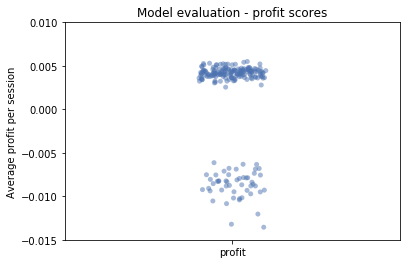

In [67]:
plt.style.use('seaborn-deep')
fig,ax=plt.subplots()
ax=sns.stripplot(data=results[['profit']],alpha=.5)

ax.set_ylim(-0.015,0.01)
ax.set_ylabel('Average profit per session')
ax.set_title('Model evaluation - profit scores')
plt.savefig('eval2.svg',bbox_inches = 'tight')

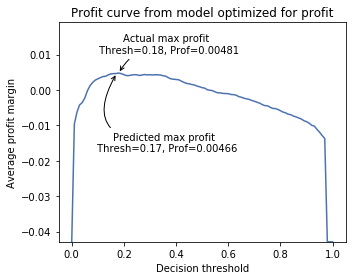

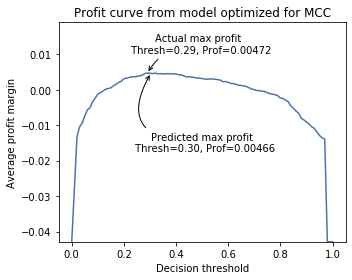

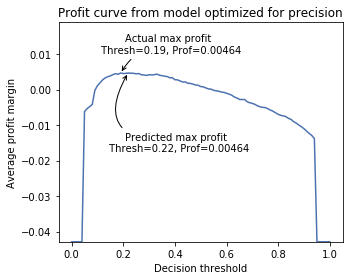

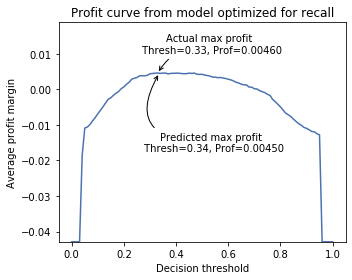

In [68]:
def xgb_sc(x):
    if x=='profit':
        return max_prof(X_final,y_final)[0]
    elif x=='MCC':
        return matthews_corrcoef(y_final,preds)
    elif x=='precision':
        return precision_score(y_final,preds)
    elif x=='recall':
        return recall_score(y_final,preds)


def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "Actual max profit \n Thresh={:.2f}, Prof={:.5f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
            arrowprops=arrowprops, bbox=bbox_props, ha="center", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+0.2,0.95), **kw)

def annot_x(x,y,pt, ax=None):

    ind=np.argwhere(x == round(pt,2))[0][0]
    xmax= pt
    ymax = y[ind]
    text= "Predicted max profit \n Thresh={:.2f}, Prof={:.5f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
            arrowprops=arrowprops, bbox=bbox_props, ha="center", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+0.2,0.5), **kw)

xgb_scores=[]

for metric in ['profit','MCC','precision','recall']:
    max_metric=metric

    df=pd.read_csv('online_shoppers_intention.csv')

    over_val=results.sort_values(by=max_metric,ascending=False).head(1)['over'].values[0]

    thresh=results.sort_values(by=max_metric,ascending=False).head(1)['thresh'].values[0]

    df['Weekend']=df['Weekend'].astype(int)
    df['Revenue']=df['Revenue'].astype(int)
    y=df['Revenue']
    X=df.drop(columns='Revenue')

    X=X[list(results.sort_values(by=max_metric,ascending=False).head(1)['cols'])[0]]

    cols=list(set(X.columns).intersection(set(['VisitorType','Browser','Region','TrafficType','OperatingSystems','Month'])))

    X=pd.get_dummies(X,columns=cols)

    X, X_final, y, y_final = train_test_split(X,y,test_size=0.2,random_state=1)

    if over_val:
        over = SMOTE(sampling_strategy='not majority')
        X,y=over.fit_resample(X,y)

    model=XGBClassifier(**results.sort_values(by=max_metric,ascending=False).head(1)['model'].values[0])
    model.fit(X,y)
    preds=model.predict(X_final)

    fig,ax=plt.subplots(figsize=(5,4))
    fp=-0.05
    x_,y_=prof_curve(X_final,y_final,fp=fp)
    ax.plot(x_,y_)
    ax.set_xlabel('Decision threshold')
    ax.set_ylabel('Average profit margin')
    ax.set_title('Profit curve from model optimized for {}'.format(max_metric))
    ax.set_ylim(min(y_),max(y_)+0.3*(max(y_)-min(y_)))

    annot_max(np.array(x_),np.array(y_),ax=ax)
    annot_x(np.array(x_),np.array(y_),thresh,ax=ax)

    fig.tight_layout()
    plt.savefig('pc_' + max_metric + '.svg',bbox_inches = 'tight')
    xgb_scores.append(xgb_sc(max_metric))



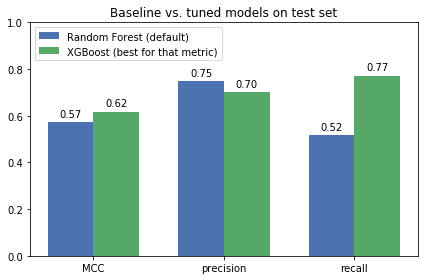

In [69]:
plt.style.use('seaborn-deep')
df_final=pd.DataFrame({'RF':rf_scores,'XGB':xgb_scores},index=['profit','MCC','precision','recall'])
df_final.iloc[1:]

labels=['MCC','precision','recall']

x = np.arange(len(labels))  
width = 0.35 

fig, ax = plt.subplots(figsize=(6,4))
rects1 = ax.bar(x - width/2, rf_scores[1:], width, label='Random Forest (default)')
rects2 = ax.bar(x + width/2, xgb_scores[1:], width, label='XGBoost (best for that metric)')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1.0)
ax.legend(loc='upper left')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_title('Baseline vs. tuned models on test set')
fig.tight_layout()
plt.savefig('results_bar.svg',bbox_inches='tight')

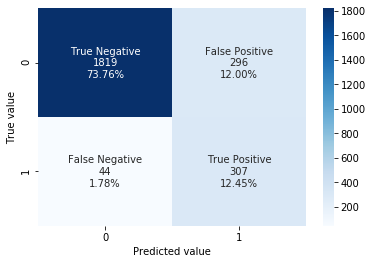

In [70]:
from sklearn.metrics import confusion_matrix

max_metric='profit'

df=pd.read_csv('online_shoppers_intention.csv')

over_val=results.sort_values(by=max_metric,ascending=False).head(1)['over'].values[0]

thresh=results.sort_values(by=max_metric,ascending=False).head(1)['thresh'].values[0]

df['Weekend']=df['Weekend'].astype(int)
df['Revenue']=df['Revenue'].astype(int)
y=df['Revenue']
X=df.drop(columns='Revenue')

X=X[list(results.sort_values(by=max_metric,ascending=False).head(1)['cols'])[0]]

cols=list(set(X.columns).intersection(set(['VisitorType','Browser','Region','TrafficType','OperatingSystems','Month'])))

X=pd.get_dummies(X,columns=cols)

X, X_final, y, y_final = train_test_split(X,y,test_size=0.2,random_state=1)

if over_val:
    over = SMOTE(sampling_strategy='not majority')
    X,y=over.fit_resample(X,y)

model=XGBClassifier(**results.sort_values(by=max_metric,ascending=False).head(1)['model'].values[0])
model.fit(X,y)
preds=model.predict(X_final)


def preds_thresh(X_test,y_test,thresh=0.17,fp=-0.05):
    probs=model.predict_proba(X_test)[:,1]
    return np.where(probs>=thresh,1,0)

cf_matrix = confusion_matrix(y_final, preds_thresh(X_final,y_final))

fig,ax=plt.subplots()

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_ylabel('True value')
ax.set_xlabel('Predicted value')
plt.savefig('cfm.svg',bbox_inches = 'tight')

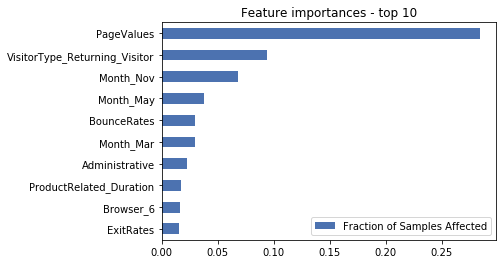

In [71]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected').tail(10)
fig =feat_scores.plot(kind='barh',title='Feature importances - top 10')
plt.savefig('imp1.svg',bbox_inches = 'tight')

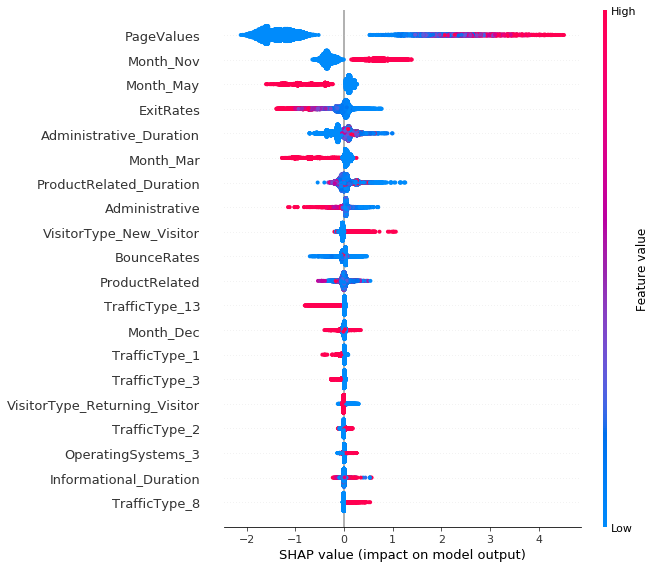

In [72]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X,show=False)

plt.savefig('shap1.svg',bbox_inches = 'tight')

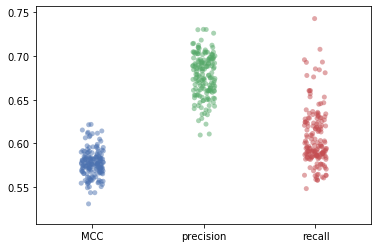

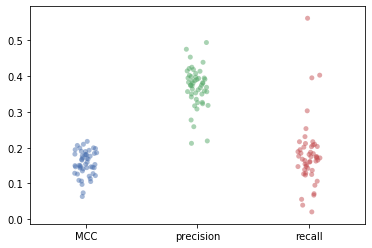

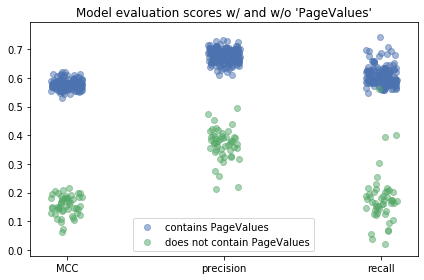

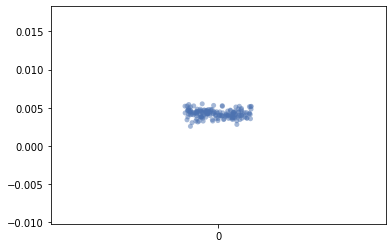

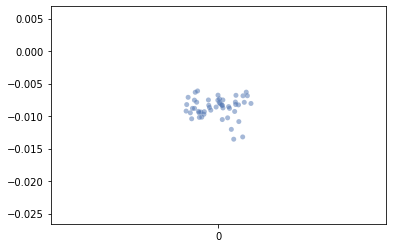

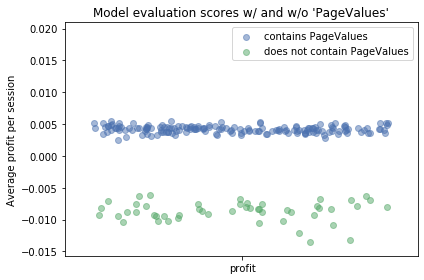

In [73]:
df_pg=results[results['cols'].apply(lambda x: 'PageValues' in x)]
df_pg2=results[results['cols'].apply(lambda x: 'PageValues' not in x)]

fig,ax=plt.subplots()
ax=sns.stripplot(data=df_pg[['MCC','precision','recall']],alpha=0.5)

lst=[]
for i in range(3):
    lst.append(ax.collections[i].get_offsets().data)

fig,ax=plt.subplots()
ax=sns.stripplot(data=df_pg2[['MCC','precision','recall']],alpha=0.5)

lst2=[]
for i in range(3):
    lst2.append(ax.collections[i].get_offsets().data)

fig,ax=plt.subplots()
ax.scatter(np.vstack(lst)[:,0],np.vstack(lst)[:,1],alpha=0.5,label='contains PageValues')

ax.scatter(np.vstack(lst2)[:,0],np.vstack(lst2)[:,1],alpha=0.5,label='does not contain PageValues')
ax.legend()
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['MCC','precision','recall'])
ax.set_title("Model evaluation scores w/ and w/o 'PageValues'")
fig.tight_layout()
plt.savefig('pv1.svg',bbox_inches='tight')

fig,ax=plt.subplots()
ax=sns.stripplot(data=df_pg['profit'],alpha=0.5)

dat = ax.collections[0].get_offsets().data
fig,ax=plt.subplots()
ax=sns.stripplot(data=list(df_pg2['profit']),alpha=0.5)

dat2= ax.collections[0].get_offsets().data
fig,ax=plt.subplots()
ax.scatter(dat[:,0],dat[:,1],alpha=0.5,label='contains PageValues')

ax.scatter(dat2[:,0],dat2[:,1],alpha=0.5,label='does not contain PageValues')
ax.legend()
ax.set_xticks([0])
ax.set_xticklabels(['profit'])
ax.set_ylabel('Average profit per session')
ax.set_title("Model evaluation scores w/ and w/o 'PageValues'")
fig.tight_layout()
plt.savefig('pv2.svg',bbox_inches='tight')